## Preambule

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from pathlib import Path
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
path_overall = current_dir = Path.cwd()

## Plot: sensitivity

In [5]:
mat = np.load(path_overall / "../Data/Sensitivity/Mat.npy")
list_samplesize = np.load(path_overall / "../Data/Sensitivity/L_samplesize.npy")
resampling = len(mat[0])

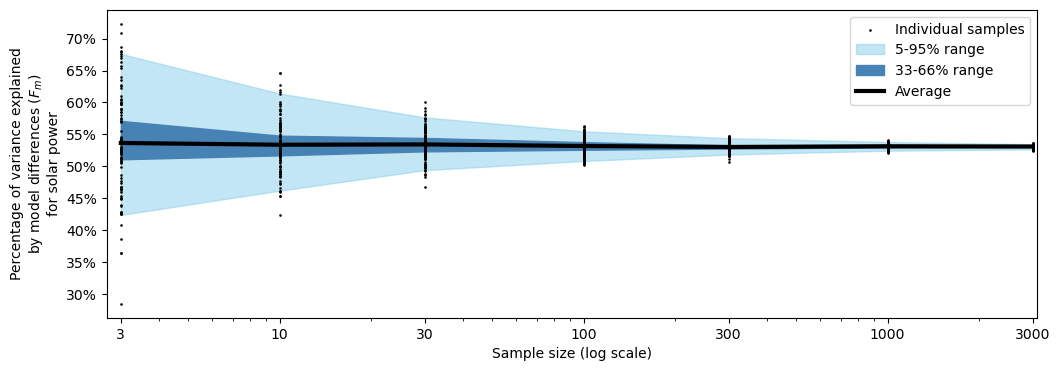

In [7]:
fig, ax = plt.subplots(figsize=(12, 4))
for i in range(resampling):
    if i ==0:
        ax.scatter(list_samplesize, mat[:, i], marker='.', c='black', s=3, label="Individual samples")
    else:
        ax.scatter(list_samplesize, mat[:, i], marker='.', c='black', s=3)

y1 = np.percentile(mat, 95, axis=1)
y0 = np.percentile(mat, 5, axis=1)
x = list_samplesize
ax.fill_between(x, y0, y1, where=y1>=y0, color='skyblue', zorder=-1e9, alpha=0.5, label="5-95% range")

y1 = np.percentile(mat, 66, axis=1)
y0 = np.percentile(mat, 33, axis=1)
x = list_samplesize
ax.fill_between(x, y0, y1, where=y1>=y0, color='steelblue', zorder=-1e9, label="33-66% range")

mn = np.mean(mat, axis=1)
ax.plot(list_samplesize, mn, c='black', lw=3, label="Average")

ax.set_xlabel("Sample size (log scale)")
ax.legend()
ax.set_ylabel("Percentage of variance explained\n"+r"by model differences ($F_m$)"+"\nfor solar power")
ax.set_yticks([0.3, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70])
ax.set_yticklabels(["30%", "35%", "40%", "45%", "50%", "55%", "60%", '65%', '70%'])
ax.set_xscale('log')
ax.set_xticks([3, 10, 30, 100, 300, 1000, 3000])
ax.set_xticklabels(['3', '10', '30', '100', '300', '1000', '3000'])
ax.set_xlim([2.7, 3100])
plt.savefig(path_overall / "../Figures/Paperfigures/SI/Figure_S1.svg", bbox_inches='tight')
plt.show()

## Plot: higher order terms

In [9]:
XRvar = xr.open_dataset(path_overall / "../Data/Output_files/Variances.nc")
all = np.zeros(shape=(6, 12))

In [10]:
for t_i, t in enumerate([2030, 2050, 2100]):
    for var_i, var in enumerate(['S_mc', 'S_z']):
        all[t_i+3*var_i, :3] = np.array(XRvar[var].sel(Variable = ['Secondary Energy|Electricity|Coal+Gas|w/o CCS',
                                                                    'Secondary Energy|Electricity|Coal|w/o CCS',
                                                                    'Secondary Energy|Electricity|Gas|w/o CCS'], Time=t))
        all[t_i+3*var_i, 3:8] = np.array(XRvar[var].sel(Variable = ["Secondary Energy|Electricity|Renewables (incl. Biomass)",
                                                                    'Secondary Energy|Electricity|Solar',
                                                                    'Secondary Energy|Electricity|Wind',
                                                                    'Secondary Energy|Electricity|Hydro',
                                                                    'Secondary Energy|Electricity|Biomass|w/o CCS'], Time=t))
        all[t_i+3*var_i, 8:] = np.array(XRvar[var].sel(Variable = ['Secondary Energy|Electricity|w/ CCS',
                                                                    'Secondary Energy|Electricity|Coal|w/ CCS',
                                                                   'Secondary Energy|Electricity|Gas|w/ CCS',
                                                                   'Secondary Energy|Electricity|Biomass|w/ CCS'], Time=t))

In [11]:
pd.DataFrame(all.T.round(2)).to_csv(path_overall / "../Data/Handling_files/HigherOrder.csv")

## Plot: opt vs sim models

In [13]:
XRraw = xr.open_dataset(path_overall / "../Data/Handling_files/XRdata.nc")
XRmeta = xr.open_dataset(path_overall / "../Data/Handling_files/XRmeta.nc")

In [14]:
year = 2050
mods_rd_cge = ['AIM', 'EPPA 6', 'GEM-E3_V2021']
mods_rd_pe = ['GCAM', 'IMAGE', 'POLES']
mods_it_ge = ['MERGE-ETL 6.0', 'MESSAGE', 'REMIND-MAgPIE', 'WITCH']
mods_it_pe = ['COFFEE 1.1', 'TIAM-ECN 1.1']

mods_sim = ["AIM", "GCAM", "IMAGE", "POLES"]
mods_opt = ["EPPA 6", "GEM-E3_V2021", "MESSAGE", "REMIND-MAgPIE", "WITCH", "COFFEE 1.1", "TIAM-ECN 1.1", "MERGE-ETL 6.0"]

modscens = np.array(XRraw.ModelScenario)
mods = np.array([i.split('|')[0] for i in modscens])

In [15]:
cols = ['tomato', 'steelblue', 'forestgreen', 'goldenrod']
cols2 = ['purple', 'brown']

fig = make_subplots(
    rows=3, cols=2,
    horizontal_spacing = 0.03,
    vertical_spacing=0.10,
    specs = [[{"type": "box"},{"type": "box"}], [{"type": "box"},{"type": "box"}], [{"type": "box"},{"type": "box"}]],
    #subplot_titles=('Electricity from fossil (without CCS)', '', 'Electricity with CCS', '', 'Electricity from renewables')
)

for var_i, var in enumerate(['Secondary Energy|Electricity|Coal+Gas|w/o CCS', 'Secondary Energy|Electricity|w/ CCS', 'Secondary Energy|Electricity|Renewables (incl. Biomass)']):
    data = []
    for mods_group_i, mods_group in enumerate([mods_rd_cge, mods_rd_pe, mods_it_ge, mods_it_pe]):
        datlist = []
        for model in mods_group:
            datlist = datlist+list(np.random.choice(np.array(XRraw.sel(Variable=var, Time=year, ModelScenario=modscens[mods == model]).Value), size=300))
        data.append(datlist)
    data2 = []
    for mods_group_i, mods_group in enumerate([mods_sim, mods_opt]):
        datlist = []
        for model in mods_group:
            try:
                datlist = datlist+list(np.random.choice(np.array(XRraw.sel(Variable=var, Time=year, ModelScenario=modscens[mods == model]).Value), size=100))
            except:
                print(model)
                continue
        data2.append(datlist)

    for mods_group_i, mods_group in enumerate([mods_rd_cge, mods_rd_pe, mods_it_ge, mods_it_pe]):
        fig.add_trace(go.Box(y=data[mods_group_i],
                            name=["Recursive-dynamic<br>CGE", "Recursive-dynamic<br>PE", "Inter-temporal<br>GE",  "Inter-temporal<br>PE"][mods_group_i],
                            fillcolor=cols[mods_group_i],
                            line_color='black',
                            marker=dict(color=cols[mods_group_i]), boxpoints='all', jitter=0.5, pointpos=-1.8, whiskerwidth=0.2, marker_size=3, line_width=1, showlegend=False), 1+var_i, 1)
    for mods_group_i, mods_group in enumerate([mods_sim, mods_opt]):
        fig.add_trace(go.Box(y=data2[mods_group_i],
                            name=["Simulation", "Optimization"][mods_group_i],
                            fillcolor=cols2[mods_group_i],
                            line_color='black',
                            marker=dict(color=cols2[mods_group_i]), boxpoints='all', jitter=0.5, pointpos=-1.8, whiskerwidth=0.2, marker_size=3, line_width=1, showlegend=False), 1+var_i, 2)

fig.update_yaxes(title='<b>Electricity from fossil<br>(without CCS)</b>', col=1,row=1)
fig.update_yaxes(title='<b>Electricity with CCS</b>', col=1,row=2)
fig.update_yaxes(title='<b>Electricity from renewables</b>', col=1,row=3)

fig.update_layout(height=900, width=1600, template='plotly_white')
fig.show(renderer='png')